## **Generate a version of MNIST dataset where one class is labelled 1 and rest are 0**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
from thalamocortex.utils import create_data_loaders, add_cue_patch

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset = "MNIST"
norm = "normalise"
save_path = "/Users/patmccarthy/Documents/thalamocortex/data"
batch_size = 32

Load source dataset

In [7]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=dataset,
                                                                norm=norm,
                                                                save_path=save_path,
                                                                batch_size=batch_size)

In [8]:
# load full training set
X_all = []
y_all = []
for X, y in iter(trainset_loader):
    X_all.append(X.detach().numpy()[:, 0, :, :])
    y_all.append(y.detach().numpy()[:])
for X, y in iter(testset_loader):
    X_all.append(X.detach().numpy()[:, 0, :, :])
    y_all.append(y.detach().numpy()[:])
X_all_arr = np.array(X_all)
y_all_arr = np.array(y_all)
# get all samples into one array
X_all_reshaped = np.zeros([X_all_arr.shape[0] * X_all_arr[0].shape[0], X_all_arr[0].shape[1], X_all_arr[0].shape[2]])
y_all_reshaped = np.zeros([y_all_arr.shape[0] * y_all_arr[0].shape[0]])
new_idx = 0
for batch_idx, X_batch in enumerate(X_all_arr):
    for point_idx, _ in enumerate(X_batch):
        X_all_reshaped[new_idx, ...] = X_all_arr[batch_idx][point_idx, :, :]
        y_all_reshaped[new_idx] = y_all_arr[batch_idx][point_idx]
        new_idx += 1

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_29149/3371650113.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_all_arr = np.array(X_all)
/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_29149/3371650113.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_all_arr = np.array(y_all)


Generate new dataset

In [13]:
X_all_reshaped.shape

(70016, 28, 28)

In [16]:
# create combined image dataset with cue patches
one_class = 1
y_new = np.empty([y_all_reshaped.shape[0]])
# shift by 100 in case one class chosen is zeo
y_new[y_all_reshaped != one_class] = 0 + 100
y_new[y_all_reshaped == one_class] = 1 + 100
y_new -= 100

Text(0.5, 1.0, 'target: 0')

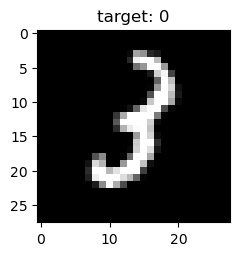

In [22]:
# plot example image as sanity check
idx = 10
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.imshow(X_all_reshaped[idx, :, :], cmap="gray")
ax.set_title(f"target: {y_new[idx]:.0f}")

In [24]:
X_all_reshaped.shape

(70016, 28, 28)

Save new dataset

In [25]:
# split into train and test sets
train_test_split = 0.8
num_train_samples = np.floor(X_all_reshaped.shape[0] * train_test_split).astype(int)
train_data = {"X": X_all_reshaped[:num_train_samples, ...],
              "y": y_new[:num_train_samples]}
test_data = {"X": X_all_reshaped[num_train_samples:, ...],
             "y": y_new[num_train_samples:]}

In [26]:
# save dataset
save_folder = Path(save_path, "BinaryMNIST")
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
with open(Path(save_folder, "train.pkl"), "wb") as handle:
    pickle.dump(train_data, handle)
with open(Path(save_folder, "test.pkl"), "wb") as handle:
    pickle.dump(test_data, handle)

Test loading dataset

In [3]:
dataset_path = "/Users/patmccarthy/Documents/thalamocortex/data/BinaryMNIST/train.pkl"

In [4]:
trainset_loader, testset_loader, metadata = create_data_loaders("BinaryMNIST", "normalise", 32, "/Users/patmccarthy/Documents/thalamocortex/data")

In [5]:
X, y = next(iter(trainset_loader))